# Programming Assignment: Numerical Optimization for Logistic Regression.

### Name: [ Han Li ]


## 0. You will do the following:

1. Read the lecture note: [click here](https://github.com/wangshusen/DeepLearning/blob/master/LectureNotes/Logistic/paper/logistic.pdf)

2. Read, complete, and run my code.

3. **Implement mini-batch SGD** and evaluate the performance.

4. Convert the .IPYNB file to .HTML file.

    * The HTML file must contain **the code** and **the output after execution**.
    
    * Missing **the output after execution** will not be graded.
    
    
5. Upload this .HTML file to your Google Drive, Dropbox, or your Github repo.  (If you submit the file to Google Drive or Dropbox, you must make the file "open-access". The delay caused by "deny of access" may result in late penalty.)

6. On Canvas, submit the Google Drive/Dropbox/Github link to the HTML file.


## Grading criteria:

1. When computing the ```gradient``` and ```objective function value``` using a batch of samples, use **matrix-vector multiplication** rather than a FOR LOOP of **vector-vector multiplications**.

2. Plot ```objective function value``` against ```epochs```. In the plot, compare GD, SGD, and MB-SGD (with $b=8$ and $b=64$). The plot must look reasonable.

# 1. Data processing

- Download the Diabete dataset from https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/diabetes
- Load the data using sklearn.
- Preprocess the data.

## 1.1. Load the data

In [149]:
from sklearn import datasets
import numpy

x_sparse, y = datasets.load_svmlight_file('diabetes')
x = x_sparse.todense()

print('Shape of x: ' + str(x.shape))
print('Shape of y: ' + str(y.shape))

Shape of x: (768, 8)
Shape of y: (768,)


## 1.2. Partition to training and test sets

In [150]:
# partition the data to training and test sets
n = x.shape[0]
n_train = 640
n_test = n - n_train

rand_indices = numpy.random.permutation(n)
train_indices = rand_indices[0:n_train]
test_indices = rand_indices[n_train:n]

x_train = x[train_indices, :]
x_test = x[test_indices, :]
y_train = y[train_indices].reshape(n_train, 1)
y_test = y[test_indices].reshape(n_test, 1)

print('Shape of x_train: ' + str(x_train.shape))
print('Shape of x_test: ' + str(x_test.shape))
print('Shape of y_train: ' + str(y_train.shape))
print('Shape of y_test: ' + str(y_test.shape))

Shape of x_train: (640, 8)
Shape of x_test: (128, 8)
Shape of y_train: (640, 1)
Shape of y_test: (128, 1)


## 1.3. Feature scaling

Use the standardization to trainsform both training and test features

In [151]:
# Standardization
import numpy

# calculate mu and sig using the training set
d = x_train.shape[1]
mu = numpy.mean(x_train, axis=0).reshape(1, d)
sig = numpy.std(x_train, axis=0).reshape(1, d)

# transform the training features
x_train = (x_train - mu) / (sig + 1E-6)

# transform the test features
x_test = (x_test - mu) / (sig + 1E-6)

print('test mean = ')
print(numpy.mean(x_test, axis=0))

print('test std = ')
print(numpy.std(x_test, axis=0))

test mean = 
[[ 0.01894973 -0.12600067 -0.02837499 -0.06600467 -0.10529198  0.01252587
  -0.10223594 -0.05094932]]
test std = 
[[0.97605818 0.92069793 1.1043023  0.92007248 0.8503511  0.92854884
  0.79098827 0.9060591 ]]


## 1.4. Add a dimension of all ones

In [152]:
n_train, d = x_train.shape
x_train = numpy.concatenate((x_train, numpy.ones((n_train, 1))), axis=1)

n_test, d = x_test.shape
x_test = numpy.concatenate((x_test, numpy.ones((n_test, 1))), axis=1)

print('Shape of x_train: ' + str(x_train.shape))
print('Shape of x_test: ' + str(x_test.shape))

Shape of x_train: (640, 9)
Shape of x_test: (128, 9)


# 2. Logistic regression model

The objective function is $Q (w; X, y) = \frac{1}{n} \sum_{i=1}^n \log \Big( 1 + \exp \big( - y_i x_i^T w \big) \Big) + \frac{\lambda}{2} \| w \|_2^2 $.

In [153]:
# Calculate the objective function value
# Inputs:
#     w: d-by-1 matrix
#     x: n-by-d matrix
#     y: n-by-1 matrix
#     lam: scalar, the regularization parameter
# Return:
#     objective function value (scalar)
def objective(w, x, y, lam):
    n, d = x.shape
    yx = numpy.multiply(y, x) # n-by-d matrix
    yxw = numpy.dot(yx, w) # n-by-1 matrix
    vec1 = numpy.exp(-yxw) # n-by-1 matrix
    vec2 = numpy.log(1 + vec1) # n-by-1 matrix
    loss = numpy.mean(vec2) # scalar
    reg = lam / 2 * numpy.sum(w * w) # scalar
    return loss + reg
    

In [154]:
# initialize w
d = x_train.shape[1]
w = numpy.zeros((d, 1))

# evaluate the objective function value at w
lam = 1E-6
objval0 = objective(w, x_train, y_train, lam)
print('Initial objective function value = ' + str(objval0))

Initial objective function value = 0.6931471805599453


# 3. Numerical optimization

## 3.1. Gradient descent


The gradient at $w$ is $g = - \frac{1}{n} \sum_{i=1}^n \frac{y_i x_i }{1 + \exp ( y_i x_i^T w)} + \lambda w$

In [155]:
# Calculate the gradient
# Inputs:
#     w: d-by-1 matrix
#     x: n-by-d matrix
#     y: n-by-1 matrix
#     lam: scalar, the regularization parameter
# Return:
#     g: g: d-by-1 matrix, full gradient
def gradient(w, x, y, lam):
    n, d = x.shape
    yx = numpy.multiply(y, x) # n-by-d matrix
    yxw = numpy.dot(yx, w) # n-by-1 matrix
    vec1 = numpy.exp(yxw) # n-by-1 matrix
    vec2 = numpy.divide(yx, 1+vec1) # n-by-d matrix
    vec3 = -numpy.mean(vec2, axis=0).reshape(d, 1) # d-by-1 matrix
    g = vec3 + lam * w
    return g

In [156]:
# Gradient descent for solving logistic regression
# Inputs:
#     x: n-by-d matrix
#     y: n-by-1 matrix
#     lam: scalar, the regularization parameter
#     stepsize: scalar
#     max_iter: integer, the maximal iterations
#     w: d-by-1 matrix, initialization of w
# Return:
#     w: d-by-1 matrix, the solution
#     objvals: a record of each iteration's objective value
def grad_descent(x, y, lam, stepsize, max_iter=100, w=None):
    n, d = x.shape
    objvals = numpy.zeros(max_iter) # store the objective values
    if w is None:
        w = numpy.zeros((d, 1)) # zero initialization
    
    for t in range(max_iter):
        objval = objective(w, x, y, lam)
        objvals[t] = objval
        print('Objective value at t=' + str(t) + ' is ' + str(objval))
        g = gradient(w, x, y, lam)
        w -= stepsize * g
    
    return w, objvals

Run gradient descent.

In [173]:
lam = 1E-6
stepsize = 1.0
w, objvals_gd = grad_descent(x_train, y_train, lam, stepsize)

Objective value at t=0 is 0.6931471805599453
Objective value at t=1 is 0.591028381324383
Objective value at t=2 is 0.5507104650535102
Objective value at t=3 is 0.5292623334486073
Objective value at t=4 is 0.5159108101016905
Objective value at t=5 is 0.5068618058821946
Objective value at t=6 is 0.5004064510880241
Objective value at t=7 is 0.4956425880462492
Objective value at t=8 is 0.4920407995941542
Objective value at t=9 is 0.4892670694050607
Objective value at t=10 is 0.4870995980138385
Objective value at t=11 is 0.485385463688193
Objective value at t=12 is 0.48401615719469243
Objective value at t=13 is 0.4829128996127569
Objective value at t=14 is 0.4820174074188493
Objective value at t=15 is 0.48128586690927627
Objective value at t=16 is 0.4806848856405292
Objective value at t=17 is 0.48018870580969814
Objective value at t=18 is 0.47977724672864064
Objective value at t=19 is 0.47943470524721155
Objective value at t=20 is 0.479148539415476
Objective value at t=21 is 0.4789087201152

## 3.2. Stochastic gradient descent (SGD)

Define $Q_i (w) = \log \Big( 1 + \exp \big( - y_i x_i^T w \big) \Big) + \frac{\lambda}{2} \| w \|_2^2 $.

The stochastic gradient at $w$ is $g_i = \frac{\partial Q_i }{ \partial w} = -\frac{y_i x_i }{1 + \exp ( y_i x_i^T w)} + \lambda w$.

In [158]:
# Calculate the objective Q_i and the gradient of Q_i
# Inputs:
#     w: d-by-1 matrix
#     xi: 1-by-d matrix
#     yi: scalar
#     lam: scalar, the regularization parameter
# Return:
#     obj: scalar, the objective Q_i
#     g: d-by-1 matrix, gradient of Q_i
def stochastic_objective_gradient(w, xi, yi, lam):
    yx = yi * xi # 1-by-d matrix
    yxw = float(numpy.dot(yx, w)) # scalar
    
    # calculate objective function Q_i
    loss = numpy.log(1 + numpy.exp(-yxw)) # scalar
    reg = lam / 2 * numpy.sum(w * w) # scalar
    obj = loss + reg
    
    # calculate stochastic gradient
    g_loss = -yx.T / (1 + numpy.exp(yxw)) # d-by-1 matrix
    g = g_loss + lam * w # d-by-1 matrix
    
    return obj, g

In [159]:
# SGD for solving logistic regression
# Inputs:
#     x: n-by-d matrix
#     y: n-by-1 matrix
#     lam: scalar, the regularization parameter
#     stepsize: scalar
#     max_epoch: integer, the maximal epochs
#     w: d-by-1 matrix, initialization of w
# Return:
#     w: the solution
#     objvals: record of each iteration's objective value
def sgd(x, y, lam, stepsize, max_epoch=100, w=None):
    n, d = x.shape
    objvals = numpy.zeros(max_epoch) # store the objective values
    if w is None:
        w = numpy.zeros((d, 1)) # zero initialization
    
    for t in range(max_epoch):
        # randomly shuffle the samples
        rand_indices = numpy.random.permutation(n)
        x_rand = x[rand_indices, :]
        y_rand = y[rand_indices, :]
        
        objval = 0 # accumulate the objective values
        for i in range(n):
            xi = x_rand[i, :] # 1-by-d matrix
            yi = float(y_rand[i, :]) # scalar
            obj, g = stochastic_objective_gradient(w, xi, yi, lam)
            objval += obj
            w -= stepsize * g
        
        stepsize *= 0.9 # decrease step size
        objval /= n
        objvals[t] = objval
        print('Objective value at epoch t=' + str(t) + ' is ' + str(objval))
    
    return w, objvals

Run SGD.

In [160]:
lam = 1E-6
stepsize = 0.1
w, objvals_sgd = sgd(x_train, y_train, lam, stepsize)

Objective value at epoch t=0 is 0.5377688961376311
Objective value at epoch t=1 is 0.5227467310902668
Objective value at epoch t=2 is 0.5181219119493573
Objective value at epoch t=3 is 0.5210687616936385
Objective value at epoch t=4 is 0.5100099302661977
Objective value at epoch t=5 is 0.5027057229472145
Objective value at epoch t=6 is 0.5045169362564741
Objective value at epoch t=7 is 0.5031272334102501
Objective value at epoch t=8 is 0.5022763432624362
Objective value at epoch t=9 is 0.5026879435806416
Objective value at epoch t=10 is 0.4967918875932574
Objective value at epoch t=11 is 0.49370281683877415
Objective value at epoch t=12 is 0.493443522603791
Objective value at epoch t=13 is 0.4922430487293254
Objective value at epoch t=14 is 0.49358129088569536
Objective value at epoch t=15 is 0.4893220457362134
Objective value at epoch t=16 is 0.4889077919229183
Objective value at epoch t=17 is 0.4880758763125007
Objective value at epoch t=18 is 0.4864115789993451
Objective value at ep

/var/folders/zx/9hd8fp4948d0r4s6gk496ky00000gn/T/ipykernel_215/2481626160.py:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yi = float(y_rand[i, :]) # scalar
/var/folders/zx/9hd8fp4948d0r4s6gk496ky00000gn/T/ipykernel_215/4188564408.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yxw = float(numpy.dot(yx, w)) # scalar


Objective value at epoch t=39 is 0.4787853325707491
Objective value at epoch t=40 is 0.4786801579848096
Objective value at epoch t=41 is 0.4785558859414656
Objective value at epoch t=42 is 0.47846048414161607
Objective value at epoch t=43 is 0.4783570166409904
Objective value at epoch t=44 is 0.4782853280280081
Objective value at epoch t=45 is 0.4782147575061903
Objective value at epoch t=46 is 0.47815633782828576
Objective value at epoch t=47 is 0.47809197825891836
Objective value at epoch t=48 is 0.47803708467073996
Objective value at epoch t=49 is 0.4779938247242903
Objective value at epoch t=50 is 0.47795218743157897
Objective value at epoch t=51 is 0.4779145427714295
Objective value at epoch t=52 is 0.4778769734402726
Objective value at epoch t=53 is 0.47784674057995946
Objective value at epoch t=54 is 0.47781661200419423
Objective value at epoch t=55 is 0.47779339931031817
Objective value at epoch t=56 is 0.47776955967909684
Objective value at epoch t=57 is 0.47774911979550555
Ob

# 4. Compare GD with SGD

Plot objective function values against epochs.

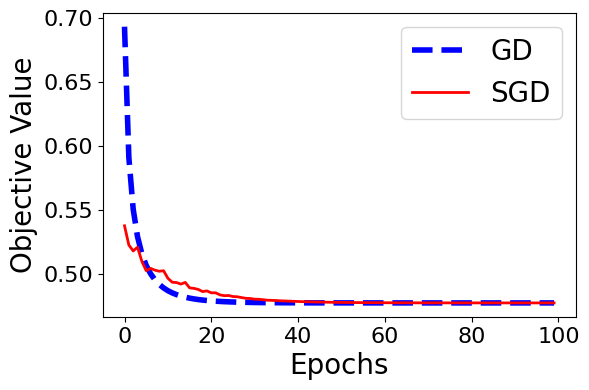

In [161]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(6, 4))

epochs_gd = range(len(objvals_gd))
epochs_sgd = range(len(objvals_sgd))

line0, = plt.plot(epochs_gd, objvals_gd, '--b', linewidth=4)
line1, = plt.plot(epochs_sgd, objvals_sgd, '-r', linewidth=2)
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('Objective Value', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend([line0, line1], ['GD', 'SGD'], fontsize=20)
plt.tight_layout()
plt.show()
fig.savefig('compare_gd_sgd.pdf', format='pdf', dpi=1200)

# 5. Prediction

In [162]:
# Predict class label
# Inputs:
#     w: d-by-1 matrix
#     X: m-by-d matrix
# Return:
#     f: m-by-1 matrix, the predictions
def predict(w, X):
    xw = numpy.dot(X, w)
    f = numpy.sign(xw)
    return f

In [163]:
# evaluate training error
f_train = predict(w, x_train)
diff = numpy.abs(f_train - y_train) / 2
error_train = numpy.mean(diff)
print('Training classification error is ' + str(error_train))

Training classification error is 0.225


In [164]:
# evaluate test error
f_test = predict(w, x_test)
diff = numpy.abs(f_test - y_test) / 2
error_test = numpy.mean(diff)
print('Test classification error is ' + str(error_test))

Test classification error is 0.1796875


# 6. Mini-batch SGD (fill the code)



## 6.1. Compute the objective $Q_I$ and its gradient using a batch of samples

Define $Q_I (w) = \frac{1}{b} \sum_{i \in I} \log \Big( 1 + \exp \big( - y_i x_i^T w \big) \Big) + \frac{\lambda}{2} \| w \|_2^2 $, where $I$ is a set containing $b$ indices randomly drawn from $\{ 1, \cdots , n \}$ without replacement.

The stochastic gradient at $w$ is $g_I = \frac{\partial Q_I }{ \partial w} = \frac{1}{b} \sum_{i \in I} \frac{- y_i x_i }{1 + \exp ( y_i x_i^T w)} + \lambda w$.

In [165]:
# Calculate the objective Q_I and the gradient of Q_I
# Inputs:
#     w: d-by-1 matrix
#     xi: b-by-d matrix
#     yi: b-by-1 matrix
#     lam: scalar, the regularization parameter
#     b: integer, the batch size
# Return:
#     obj: scalar, the objective Q_i
#     g: d-by-1 matrix, gradient of Q_i
def mb_stochastic_objective_gradient(w, xi, yi, lam, b):
    # Fill the function
    # Follow the implementation of stochastic_objective_gradient
    # Use matrix-vector multiplication; do not use FOR LOOP of vector-vector multiplications
    yx = numpy.multiply(yi, xi)
    yxw = numpy.dot(yx, w)
    loss = numpy.mean(numpy.log(1 + numpy.exp(-yxw)))
    reg = lam / 2 * numpy.dot(w.T, w)
    obj = loss + reg

    exp_yxw = numpy.exp(yxw)
    g_loss = - numpy.mean(yx / (1 + exp_yxw), axis=0).reshape(-1, 1)
    g = g_loss + lam * w
    obj = obj.item() # convert form (1,1) to scalar

    return obj, g

## 6.2. Implement mini-batch SGD

Hints:
1. In every epoch, randomly permute the $n$ samples (just like SGD).
2. Each epoch has $\frac{n}{b}$ iterations. In every iteration, use $b$ samples, and compute the gradient and objective using the ``mb_stochastic_objective_gradient`` function. In the next iteration, use the next $b$ samples, and so on.


In [166]:
# Mini-Batch SGD for solving logistic regression
# Inputs:
#     x: n-by-d matrix
#     y: n-by-1 matrix
#     lam: scalar, the regularization parameter
#     b: integer, the batch size
#     stepsize: scalar
#     max_epoch: integer, the maximal epochs
#     w: d-by-1 matrix, initialization of w
# Return:
#     w: the solution
#     objvals: record of each iteration's objective value
def mb_sgd(x, y, lam, b, stepsize, max_epoch=100, w=None):
    # Fill the function
    # Follow the implementation of sgd
    # Record one objective value per epoch (not per iteration!)
    n,d = x.shape
    objvals = numpy.zeros(max_epoch)
    if w is None:
        w = numpy.zeros((d,1))

    for t in range(max_epoch):
        rand_indices = numpy.random.permutation(n)
        x_rand = x[rand_indices, :]
        y_rand = y[rand_indices, :]

        objval = 0
        for i in range(0, n, b):
            xi = x_rand[i:i+b, :]
            yi = y_rand[i:i+b, :]
            obj, g = mb_stochastic_objective_gradient(w, xi, yi, lam, b)
            objval += obj * xi.shape[0]
            w -= stepsize * g

        stepsize *= 0.9 # decrease step size
        objval /= n
        objvals[t] = objval

        print(f'Epoch {t}, Objective = {objval:.4f}')

    
    return w, objvals

## 6.3. Run MB-SGD

In [167]:
# MB-SGD with batch size b=8
lam = 1E-6 # do not change
b = 8 # do not change
stepsize = 0.1 # you must tune this parameter
# Answer: 0.1 is a good stepsize choice

w, objvals_mbsgd8 = mb_sgd(x_train, y_train, lam, b, stepsize)

Epoch 0, Objective = 0.5521
Epoch 1, Objective = 0.4926
Epoch 2, Objective = 0.4878
Epoch 3, Objective = 0.4848
Epoch 4, Objective = 0.4831
Epoch 5, Objective = 0.4831
Epoch 6, Objective = 0.4819
Epoch 7, Objective = 0.4819
Epoch 8, Objective = 0.4814
Epoch 9, Objective = 0.4813
Epoch 10, Objective = 0.4802
Epoch 11, Objective = 0.4808
Epoch 12, Objective = 0.4804
Epoch 13, Objective = 0.4799
Epoch 14, Objective = 0.4795
Epoch 15, Objective = 0.4795
Epoch 16, Objective = 0.4793
Epoch 17, Objective = 0.4791
Epoch 18, Objective = 0.4790
Epoch 19, Objective = 0.4788
Epoch 20, Objective = 0.4786
Epoch 21, Objective = 0.4786
Epoch 22, Objective = 0.4785
Epoch 23, Objective = 0.4783
Epoch 24, Objective = 0.4783
Epoch 25, Objective = 0.4783
Epoch 26, Objective = 0.4782
Epoch 27, Objective = 0.4781
Epoch 28, Objective = 0.4780
Epoch 29, Objective = 0.4781
Epoch 30, Objective = 0.4779
Epoch 31, Objective = 0.4779
Epoch 32, Objective = 0.4778
Epoch 33, Objective = 0.4779
Epoch 34, Objective = 0.

Epoch 0, Objective = 0.6876
Epoch 1, Objective = 0.6762
Epoch 2, Objective = 0.6667
Epoch 3, Objective = 0.6586
Epoch 4, Objective = 0.6518
Epoch 5, Objective = 0.6460
Epoch 6, Objective = 0.6411
Epoch 7, Objective = 0.6368
Epoch 8, Objective = 0.6331
Epoch 9, Objective = 0.6299
Epoch 10, Objective = 0.6270
Epoch 11, Objective = 0.6246
Epoch 12, Objective = 0.6224
Epoch 13, Objective = 0.6205
Epoch 14, Objective = 0.6188
Epoch 15, Objective = 0.6173
Epoch 16, Objective = 0.6160
Epoch 17, Objective = 0.6148
Epoch 18, Objective = 0.6138
Epoch 19, Objective = 0.6128
Epoch 20, Objective = 0.6120
Epoch 21, Objective = 0.6113
Epoch 22, Objective = 0.6106
Epoch 23, Objective = 0.6100
Epoch 24, Objective = 0.6095
Epoch 25, Objective = 0.6090
Epoch 26, Objective = 0.6086
Epoch 27, Objective = 0.6082
Epoch 28, Objective = 0.6079
Epoch 29, Objective = 0.6076
Epoch 30, Objective = 0.6073
Epoch 31, Objective = 0.6071
Epoch 32, Objective = 0.6069
Epoch 33, Objective = 0.6067
Epoch 34, Objective = 0.

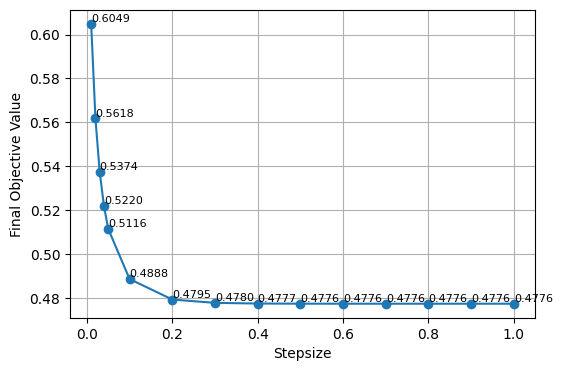

In [179]:
stepsizes = [0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
objvals_dict = {}

for stepsize in stepsizes:
    w, objvals = mb_sgd(x_train, y_train, lam, b, stepsize)
    objvals_dict[stepsize] = objvals

final_values = [objvals[-1] for objvals in objvals_dict.values()]

plt.figure(figsize=(6, 4))
plt.plot(stepsizes, final_values, marker='o')
plt.xlabel('Stepsize')
plt.ylabel('Final Objective Value')
plt.grid(True)

# Value
for x, y in zip(stepsizes, final_values):
    plt.text(x, y, f'{y:.4f}', ha='left', va='bottom', fontsize=8)

plt.show()

#### Answer: 0.5 is a good choice for stepsize

# 7. Plot and compare GD, SGD, and MB-SGD

You are required to compare the following algorithms:

- Gradient descent (GD)

- SGD

- MB-SGD with b=8

- MB-SGD with b=64

Follow the code in Section 4 to plot ```objective function value``` against ```epochs```. There should be four curves in the plot; each curve corresponds to one algorithm.

Hint: Logistic regression with $\ell_2$-norm regularization is a strongly convex optimization problem. All the algorithms will converge to the same solution. **In the end, the ``objective function value`` of the 4 algorithms will be the same. If not the same, your implementation must be wrong. Do NOT submit wrong code and wrong result!**

Objective value at t=0 is 0.6931471805599453
Objective value at t=1 is 0.635486894935217
Objective value at t=2 is 0.5988664306639844
Objective value at t=3 is 0.574209588665333
Objective value at t=4 is 0.5566633342201209
Objective value at t=5 is 0.5436024231742277
Objective value at t=6 is 0.5335317622064608
Objective value at t=7 is 0.5255505400544526
Objective value at t=8 is 0.5190872748620222
Objective value at t=9 is 0.5137627106277874
Objective value at t=10 is 0.5093152001292225
Objective value at t=11 is 0.5055581170655197
Objective value at t=12 is 0.50235448311605
Objective value at t=13 is 0.4996012609703064
Objective value at t=14 is 0.4972192925018502
Objective value at t=15 is 0.4951466522155589
Objective value at t=16 is 0.49333413353991495
Objective value at t=17 is 0.49174210590558776
Objective value at t=18 is 0.49033827619400416
Objective value at t=19 is 0.4890960613132365
Objective value at t=20 is 0.48799338294119754
Objective value at t=21 is 0.487011759878144

/var/folders/zx/9hd8fp4948d0r4s6gk496ky00000gn/T/ipykernel_215/2481626160.py:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yi = float(y_rand[i, :]) # scalar
/var/folders/zx/9hd8fp4948d0r4s6gk496ky00000gn/T/ipykernel_215/4188564408.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yxw = float(numpy.dot(yx, w)) # scalar


Objective value at epoch t=32 is 0.488100054487916
Objective value at epoch t=33 is 0.48790465448974396
Objective value at epoch t=34 is 0.48626807039581454
Objective value at epoch t=35 is 0.4854520423398839
Objective value at epoch t=36 is 0.48401011889884976
Objective value at epoch t=37 is 0.4839137508816028
Objective value at epoch t=38 is 0.4834407030164348
Objective value at epoch t=39 is 0.48367783758963556
Objective value at epoch t=40 is 0.48262584494370325
Objective value at epoch t=41 is 0.48184106246547787
Objective value at epoch t=42 is 0.48162501380578576
Objective value at epoch t=43 is 0.4814618065111927
Objective value at epoch t=44 is 0.48103201979790117
Objective value at epoch t=45 is 0.4805030158395813
Objective value at epoch t=46 is 0.48038843675173926
Objective value at epoch t=47 is 0.4799245029486617
Objective value at epoch t=48 is 0.4798825720171928
Objective value at epoch t=49 is 0.47968812167964126
Objective value at epoch t=50 is 0.479459441795853
Obje

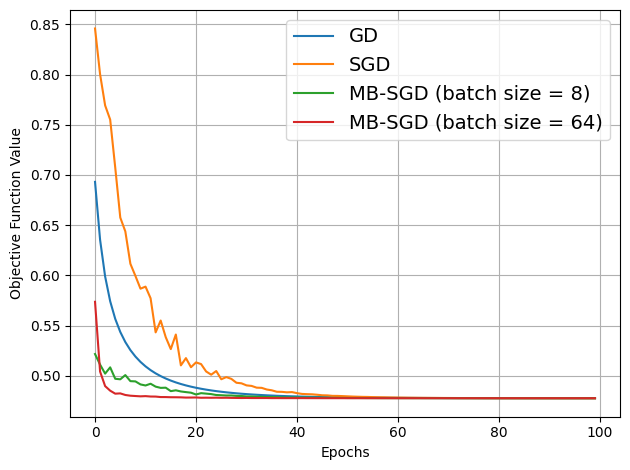

In [180]:
# plot the 4 curves:

lam = 1e-6
max_epoch = 100
stepsize = 0.5
w_init = numpy.zeros((x_train.shape[1], 1))

# Gradient descent (GD)
w_gd, objvals_gd = grad_descent(x_train, y_train, lam, stepsize)

# SGD
w_sgd, objvals_sgd = sgd(x_train, y_train, lam, stepsize)

# MB-SGD with b=8
b=8
w_mb8, objvals_mb8 = mb_sgd(x_train, y_train, lam, b, stepsize)

# B-SGD with b=64
b=64
w_mb64, objvals_mb64 = mb_sgd(x_train, y_train, lam, b, stepsize)

epochs = range(max_epoch)


plt.plot(epochs, objvals_gd, label='GD')
plt.plot(epochs, objvals_sgd, label='SGD')
plt.plot(epochs, objvals_mb8, label='MB-SGD (batch size = 8)')
plt.plot(epochs, objvals_mb64, label='MB-SGD (batch size = 64)')

plt.xlabel('Epochs')
plt.ylabel('Objective Function Value')
plt.legend(fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.show()